# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [121]:
! git clone https://github.com/ds4e/wrangling


fatal: destination path 'wrangling' already exists and is not an empty directory.


In [122]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [123]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [124]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [125]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('/content/wrangling/src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(60, 6)


,title,price,year,link,brand,age
0,2009 honda fit sport,3400,2009.0,https://charlottesville.craigslist.org/cto/d/c...,honda,16.0
1,2014 chrysler town & country,6000,2014.0,https://charlottesville.craigslist.org/cto/d/w...,missing,11.0
2,2001 mercedes e320,2000,2001.0,https://charlottesville.craigslist.org/cto/d/s...,missing,24.0
3,2012 honda civic lx,5900,2012.0,https://charlottesville.craigslist.org/cto/d/h...,honda,13.0
4,toyota camry 2008,3000,2008.0,https://charlottesville.craigslist.org/cto/d/s...,toyota,17.0


In [126]:
df

,title,price,year,link,brand,age
0,2009 honda fit sport,3400,2009.0,https://charlottesville.craigslist.org/cto/d/c...,honda,16.0
1,2014 chrysler town & country,6000,2014.0,https://charlottesville.craigslist.org/cto/d/w...,missing,11.0
2,2001 mercedes e320,2000,2001.0,https://charlottesville.craigslist.org/cto/d/s...,missing,24.0
3,2012 honda civic lx,5900,2012.0,https://charlottesville.craigslist.org/cto/d/h...,honda,13.0
4,toyota camry 2008,3000,2008.0,https://charlottesville.craigslist.org/cto/d/s...,toyota,17.0
5,toyota tundra 2013,16000,2013.0,https://charlottesville.craigslist.org/cto/d/s...,toyota,12.0
6,chev van,4000,NaN,https://charlottesville.craigslist.org/cto/d/p...,missing,NaN
7,1994 dodge ram b1500 van,9750,1994.0,https://charlottesville.craigslist.org/cto/d/l...,dodge,31.0
8,2008 ford f350 super duty,9500,2008.0,https://charlottesville.craigslist.org/cto/d/n...,ford,17.0
9,2006 acura tl,3000,2006.0,https://charlottesville.craigslist.org/cto/d/b...,acura,19.0


With the data in and wrangled, we can now do some analysis:

count       60.000000
mean     10114.983333
std      10931.572011
min       2000.000000
25%       3500.000000
50%       6500.000000
75%      11100.000000
max      62800.000000
Name: price, dtype: float64


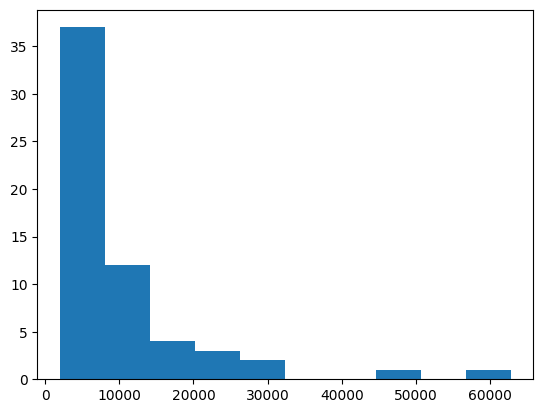

count    56.000000
mean     21.553571
std      14.867805
min       4.000000
25%      12.750000
50%      17.000000
75%      22.000000
max      68.000000
Name: age, dtype: float64


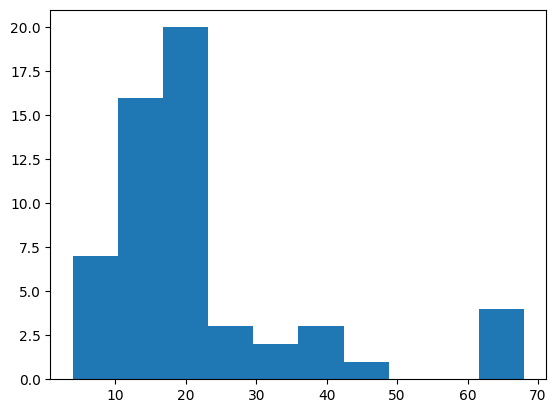

In [127]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [128]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                         \
           count          mean           std      min      25%      50%   
brand                                                                     
acura        2.0   5250.000000   3181.980515   3000.0   4125.0   5250.0   
audi         1.0  11000.000000           NaN  11000.0  11000.0  11000.0   
bmw          2.0   8750.000000   1767.766953   7500.0   8125.0   8750.0   
chevrolet    2.0  18500.000000   5656.854249  14500.0  16500.0  18500.0   
chevy        2.0   2950.000000     70.710678   2900.0   2925.0   2950.0   
dodge        2.0   6875.000000   4065.863992   4000.0   5437.5   6875.0   
ford         8.0  15687.500000  14713.787266   4000.0   6625.0  11500.0   
gmc          2.0  16500.000000  13435.028843   7000.0  11750.0  16500.0   
honda        9.0   9711.111111   8211.035934   3000.0   4700.0   6500.0   
jeep         3.0   7900.000000   1429.160593   6250.0   7475.0   8700.0   
kia          1.0   2500.000000           NaN   2500.0   2500.0   2500.0   
lexus        2.0  11175.000000    318.198052  10950.0  11062.5  11175.0   
missing     15.0   8973.266667  15819.353610   2000.0   3225.0   3500.0   
mitsubishi   1.0   6800.000000           NaN   6800.0   6800.0   6800.0   
tesla        1.0  26900.000000           NaN  26900.0  26900.0  26900.0   
toyota       5.0   7880.000000   5392.309338   3000.0   4500.0   5200.0   
volkswagen   2.0   4550.000000   2757.716447   2600.0   3575.0   4550.0   

                              
                75%      max  
brand                         
acura        6375.0   7500.0  
audi        11000.0  11000.0  
bmw          9375.0  10000.0  
chevrolet   20500.0  22500.0  
chevy        2975.0   3000.0  
dodge        8312.5   9750.0  
ford        18125.0  49500.0  
gmc         21250.0  26000.0  
honda       13000.0  29000.0  
jeep         8725.0   8750.0  
kia          2500.0   2500.0  
lexus       11287.5  11400.0  
missing      5124.5  62800.0  
mitsubishi   6800.0   6800.0  
tesla       26900.0  26900.0  
toyota      10700.0  16000.0  
volkswagen   5525.0   6500.0

In [129]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
           count       mean        std   min    25%   50%    75%   max
brand                                                                 
acura        2.0  15.000000   5.656854  11.0  13.00  15.0  17.00  19.0
audi         1.0   8.000000        NaN   8.0   8.00   8.0   8.00   8.0
bmw          2.0  16.500000   0.707107  16.0  16.25  16.5  16.75  17.0
chevrolet    2.0  52.000000  22.627417  36.0  44.00  52.0  60.00  68.0
chevy        1.0  21.000000        NaN  21.0  21.00  21.0  21.00  21.0
dodge        2.0  26.500000   6.363961  22.0  24.25  26.5  28.75  31.0
ford         8.0  18.500000   7.982123   8.0  12.50  19.5  22.00  33.0
gmc          1.0  41.000000        NaN  41.0  41.00  41.0  41.00  41.0
honda        9.0  12.555556   4.503085   4.0  11.00  13.0  15.00  19.0
jeep         3.0  14.333333   3.214550  12.0  12.50  13.0  15.50  18.0
kia          1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
lexus        2.0  17.000000   5.656854  13.0  15.00  17.0  19.00  21.0
missing     13.0  29.230769  21.680075   7.0  13.00  21.0  36.00  68.0
mitsubishi   1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
tesla        1.0   7.000000        NaN   7.0   7.00   7.0   7.00   7.0
toyota       5.0  18.400000   4.878524  12.0  17.00  17.0  21.00  25.0
volkswagen   2.0  33.000000  15.556349  22.0  27.50  33.0  38.50  44.0

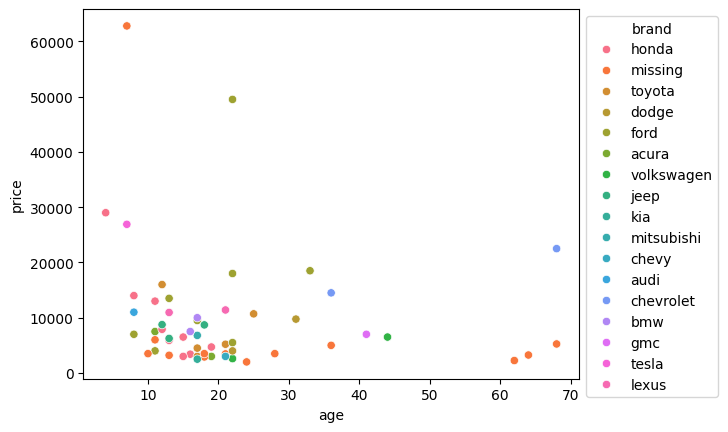

In [130]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.633724 -0.126376
log_age    -0.126376  0.344212
           log_price   log_age
log_price   1.000000 -0.277816
log_age    -0.277816  1.000000


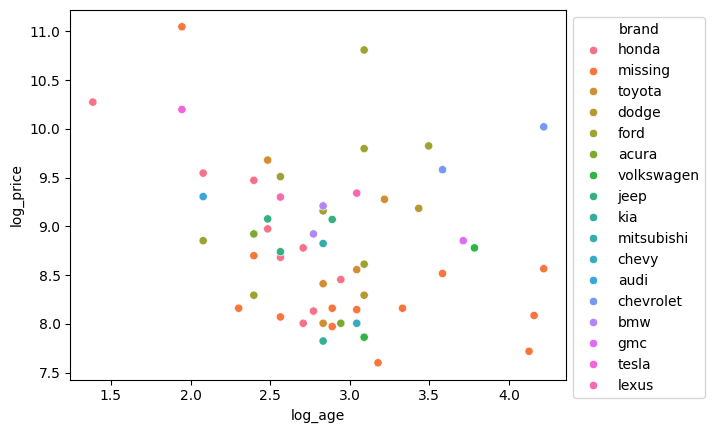

In [131]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

In [132]:
url = 'https://charlottesville.craigslist.org/search/ata?purveyor=owner#search=1~gallery~0~0' # I picked antiques
raw = requests.get(url,headers=header) # Get page

In [133]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

In [134]:
data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']

    # Get brand from the title string:
    #words = title.split()
    #hits = [word for word in words if word in brands] # Find brands in the title
    #if len(hits) == 0:
    #    brand = 'missing'
    #else:
    #    brand = hits[0]

    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    #data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})
    data.append({'title':title,'price':price,'year':year,'link':link})

In [135]:
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('/content/wrangling/src/craigslist_cville_antiques.csv') # Save data in case of a disaster
df.head()

(148, 5)


,title,price,year,link,age
0,crisa 5 gallon carboy,75,NaN,https://charlottesville.craigslist.org/atq/d/n...,NaN
1,vintage / antique genuine taylor tot baby stro...,35,NaN,https://charlottesville.craigslist.org/atq/d/p...,NaN
2,"lalique perruches vase, 1919 signed",29995,1919.0,https://charlottesville.craigslist.org/atq/d/s...,106.0
3,beautfiul and sensuous lalique baccantes vase,2895,NaN,https://charlottesville.craigslist.org/atq/d/s...,NaN
4,rene lalique archers clear-frosted vase,9995,NaN,https://charlottesville.craigslist.org/atq/d/s...,NaN


In [141]:
sum(df['year'].isna())/len(df) # 91% of antiques did not have year in title, so keep this in mind

0.918918918918919

In [143]:
len(df[df['year'].isna()==False]) # In fact, only 12 have years in name, but alas.

12

count      148.000000
mean       613.020270
std       2699.404909
min          0.000000
25%         39.500000
50%         80.000000
75%        250.000000
max      29995.000000
Name: price, dtype: float64


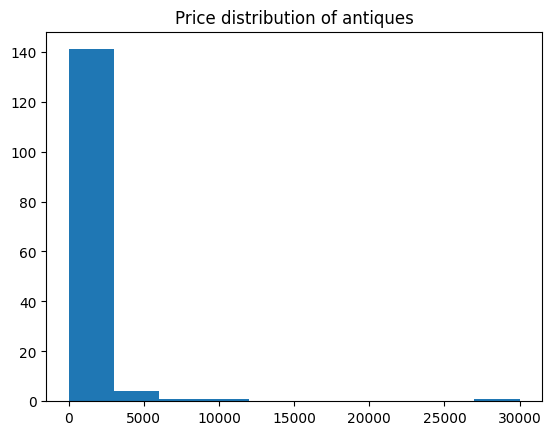

count     12.000000
mean      82.416667
std       28.285744
min       40.000000
25%       61.500000
50%       86.500000
75%      105.250000
max      120.000000
Name: age, dtype: float64


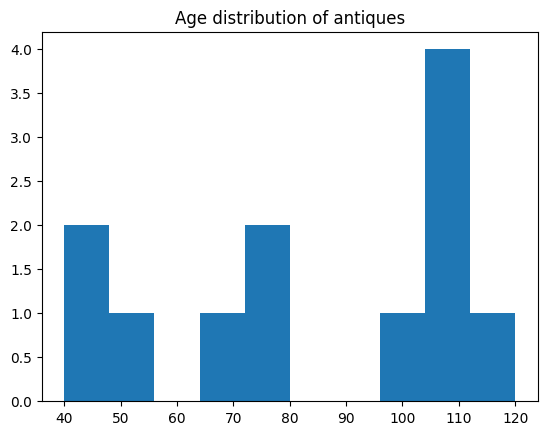

In [136]:
# Below is price distribution of all antiques, and age distribution of 12 antiques with year.

print(df['price'].describe())
df['price'].hist(grid=False)
plt.title('Price distribution of antiques')
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.title('Age distribution of antiques')
plt.show()

In [137]:
df.sort_values(by='price',ascending=False) # the most expensive antique is the lalique perruches vase

,title,price,year,link,age
2,"lalique perruches vase, 1919 signed",29995,1919.0,https://charlottesville.craigslist.org/atq/d/s...,106.0
4,rene lalique archers clear-frosted vase,9995,NaN,https://charlottesville.craigslist.org/atq/d/s...,NaN
140,rare antique: egyptian throne replica,6500,NaN,https://charlottesville.craigslist.org/atq/d/c...,NaN
37,solid cherry drop leaf table,5000,NaN,https://charlottesville.craigslist.org/atq/d/s...,NaN
139,rare find antique: victorian cathedral style b...,3500,NaN,https://charlottesville.craigslist.org/atq/d/c...,NaN
...,...,...,...,...,...
8,vintage laguna melmac green design dishes,1,NaN,https://charlottesville.craigslist.org/atq/d/t...,NaN
134,river town antiques sale,0,NaN,https://charlottesville.craigslist.org/atq/d/s...,NaN
33,looking for yellow yellow paint,0,NaN,https://charlottesville.craigslist.org/atq/d/c...,NaN
87,antique cavalier cedar hope chest with origina...,0,NaN,https://charlottesville.craigslist.org/atq/d/d...,NaN


Text(70, 29500, 'lalique perruches vase, 1919 signed')

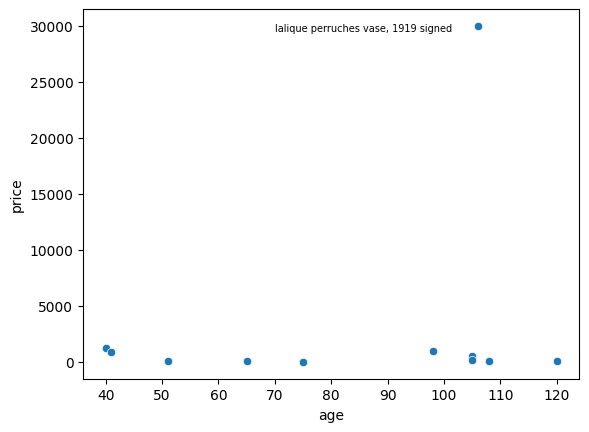

In [138]:
ax = sns.scatterplot(data=df, x='age', y='price')
plt.text(x=70, y=29500, s="lalique perruches vase, 1919 signed", fontsize=7, color='black')

# Here we can see that this vase is not the oldest, but by far the most expensive (of antiques with year in title)


<Axes: xlabel='age'>

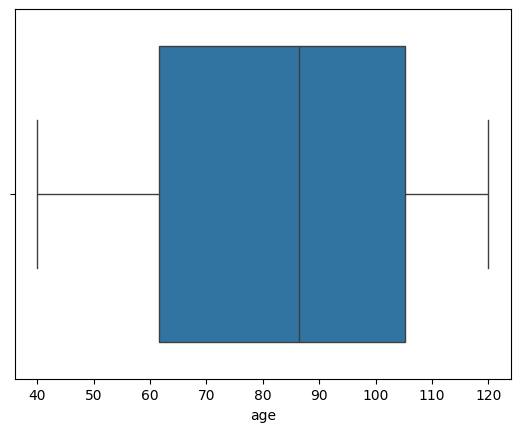

In [139]:
sns.boxplot(x=df['age']) # no outliers in terms of age.